### LDA for captions posted below the pictures
Latent Dirichlet Allocation (LDA) is a three-level hierarchical Bayesian model for topic inference. 

#### Libraries

In [230]:

#Libraries for files
#from pandas import DataFrame

from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import spatial

import re
#from pandasql import *
import gensim
# libraries for TFIDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
#nltk.download('wordnet')


import gensim
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint


# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn



In [234]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/student/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Importing the posted captions from the pickled database built by Arun

Remove non-text caracters in case they exist in the text post: 

In [236]:
#Read the pickle database to get the columns for the object descriptions

import pickle

with open('instagram_database_reuters_3.pickle', 'rb') as f:
    data = pickle.load(f)

df=DataFrame(data)
df.head()


,username,postid,date,url,img_link,vid_link,caption,location_name,location_link,likes,views,image_caption,combined_caption
0,NULL,BkH69K-n1v9,2018-06-17T11:16:17.000Z,https://www.instagram.com/p/BkH69K-n1v9/,https://scontent-dfw5-1.cdninstagram.com/vp/1c...,None,People gather for an open-air yoga session nea...,NULL,NULL,8715,NONE,"a crowd of people standing on top of a field, ...",People gather for an open-air yoga session nea...
1,NULL,BembSYkHbeT,2018-01-31T04:27:39.000Z,https://www.instagram.com/p/BembSYkHbeT/,https://scontent-dfw5-1.cdninstagram.com/vp/27...,None,"North Korean defector Ji Seong-ho, currently a...",NULL,NULL,3458,NONE,a group of men standing next to each other in ...,"North Korean defector Ji Seong-ho, currently a..."
2,NULL,BpUCo6xj3ct,2018-10-24T10:51:17.000Z,https://www.instagram.com/p/BpUCo6xj3ct/,https://scontent-dfw5-1.cdninstagram.com/vp/60...,None,Men work on cables connecting power transmissi...,NULL,NULL,8232,NONE,a group of people riding skis on top of a ski ...,Men work on cables connecting power transmissi...
3,NULL,BjKcT5UH2b_,2018-05-24T14:14:50.000Z,https://www.instagram.com/p/BjKcT5UH2b_/,https://scontent-dfw5-1.cdninstagram.com/vp/3d...,None,A mahout rides his elephant in the Yamuna rive...,NULL,NULL,9371,NONE,"a man riding an elephant in the water, a man i...",A mahout rides his elephant in the Yamuna rive...
4,NULL,BczdWEFnkQr,2017-12-17T12:52:58.000Z,https://www.instagram.com/p/BczdWEFnkQr/,https://scontent-dfw5-1.cdninstagram.com/vp/f8...,None,Photographers take pictures as the Soyuz MS-07...,NULL,NULL,6184,NONE,a group of people standing next to each other ...,Photographers take pictures as the Soyuz MS-07...


In [237]:
# Create an index to refer to a sample post later as a sample document 
df['index']=data.index

# select only the variables needed in this model and create a df: 
documents = df[['caption', 'likes' ,'index']]
documents.head()


,caption,likes,index
0,People gather for an open-air yoga session nea...,8715,0
1,"North Korean defector Ji Seong-ho, currently a...",3458,1
2,Men work on cables connecting power transmissi...,8232,2
3,A mahout rides his elephant in the Yamuna rive...,9371,3
4,Photographers take pictures as the Soyuz MS-07...,6184,4


In [238]:
documents['likes']

0       8715
1       3458
2       8232
3       9371
4       6184
5       5798
6      13139
7       5068
8       3981
9       6435
10      3329
11      3546
12      4435
13      6815
14     27330
15     36651
16      9179
17      7361
18      9454
19      2767
20      4415
21      2557
22      4063
23     12827
24      4358
25      3282
26      3486
27      4620
28     10342
29      4367
       ...  
663     7900
664     7076
665    14353
666     6377
667     6746
668    31010
669     5645
670     6915
671     4660
672     7226
673     6526
674     5828
675     8417
676     2137
677     8117
678     8439
679     4437
680     7071
681     4478
682     5464
683     3310
684     9845
685     5541
686    13542
687     5469
688     4021
689     6867
690     4675
691     9675
692     3310
Name: likes, Length: 693, dtype: object

In [239]:

doc = documents.caption

# Remove Emails
doc = [re.sub('\S*@\S*\s?', '', sent) for sent in doc]

# Remove new line characters
doc = [re.sub('\s+', ' ', sent) for sent in doc]

# Remove distracting single quotes
doc = [re.sub("\'", "", sent) for sent in doc]
# Remove #
doc = [re.sub("\#", "", sent) for sent in doc]

# Remove /
doc = [re.sub("\/", "", sent) for sent in doc]

# Remove reuterphotos
doc = [re.sub("reuterphotos", " ", sent) for sent in doc]

# Remove reuters
doc = [re.sub("reuters", " ", sent) for sent in doc]

# Remove reuter
doc = [re.sub("reuter", " ", sent) for sent in doc]

pprint(doc[:1])

['People gather for an open-air yoga session near the Eiffel tower in Paris, '
 'France June 17, 2018. REUTERSPhilippe Wojazer paris france yoga eiffeltower  '
 'photos  ']


#### Tokenization

Tokenizing using gensim library: as it has a function simple_preprocess()
Breaking up the posted text into sentences. 
After that we will tokenize each sentence into a list of words.
Gensim’s simple_preprocess() is great for this. 
deacc=True to remove the punctuations.

In [240]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words =tuple( sent_to_words(doc))

print(data_words[:1])

(['people', 'gather', 'for', 'an', 'open', 'air', 'yoga', 'session', 'near', 'the', 'eiffel', 'tower', 'in', 'paris', 'france', 'june', 'reutersphilippe', 'wojazer', 'paris', 'france', 'yoga', 'eiffeltower', 'photos'],)


#### Lemmatization

Lemmatization : converting words to its root word.
The advantage of this is, we get to reduce the total number of unique words in the dictionary. 
As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns. You can expect better topics to be generated in the end.

In [241]:

stemmer = PorterStemmer()



def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
        try:
            result.remove('REUTER')
        except:
            pass
        try:
            result.remove('#REUTER')
        except:
            pass
        try:
            result.remove('reuter')
        except:
            pass
        try:
            result.remove('#reuter')
        except:
            pass
        try:
            result.remove('reutersphotos')
        except:
            pass
        try:
            result.remove('#reutersphotos')
        except:
            pass
        try:
            result.remove('reutersphoto')
        except:
            pass
        try:
            result.remove('#reutersphoto')
        except:
            pass
        try:
            result.remove('reuters')
        except:
            pass
        try:
            result.remove('#reuters')
        except:
            pass
    
    return result

In [242]:
# sample document at index 3 is being tested to see if our tokenizer and lammitizer work:

doc_sample = documents[documents['index'] == 3].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')

# apply the function we defined earlier to test the sample doc:
print(preprocess(doc_sample))


original document: 
['A', 'mahout', 'rides', 'his', 'elephant', 'in', 'the', 'Yamuna', 'river', 'on', 'a', 'hot', 'summer', 'day', 'in', 'New', 'Delhi,', 'India', 'May', '24,', '2018.', 'REUTERS/Adnan', 'Abidi', '@adnanabidi', '#india', '#summer', '#newdelhi', '#reuters', '#reutersphotos']


 tokenized and lemmatized document: 
['mahout', 'rid', 'eleph', 'yamuna', 'river', 'summer', 'delhi', 'india', 'adnan', 'abidi', 'adnanabidi', 'india', 'summer', 'newdelhi']


In [243]:
#Since the test document worked we can apply to the whole set of documents we have
#Preprocess the caption text, saving the results as "data_lemmatized"

data_lemmatized  = documents['caption'].map(preprocess)
data_lemmatized[:10]

0    [peopl, gather, open, yoga, session, near, eif...
1    [north, korean, defector, seong, current, stud...
2    [work, cabl, connect, power, transmiss, tower,...
3    [mahout, rid, eleph, yamuna, river, summer, de...
4    [photograph, pictur, soyuz, spacecraft, carri,...
5    [drone, carri, bag, creation, dolc, gabbana, a...
6    [month, babi, eleph, sit, insid, eleph, breed,...
7    [blacken, landscap, show, wildfir, damag, near...
8    [manchest, citi, oleksandr, zinchenko, react, ...
9    [guest, arriv, loui, vuitton, fashion, near, l...
Name: caption, dtype: object

The training dataset for LDA topic model algorithm requires a document word matrix as the main input.
To create one, we will use CountVectorizer. 
In the below code, we chose to convert all words to lowercase, and remove stopwords.



Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.
If you want to materialize it in a 2D array format, call the todense() method of the sparse matrix like its done in the next step.

In [244]:
# configuring the vectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words="english", analyzer='word',  max_df=1.0, min_df=1, max_features=2000)

#APplying the the transform to our data in order to get the word matrix
data_vectorized = vectorizer.fit_transform(data_lemmatized)



8. Check the Sparsicity
Sparsicity is refering to the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.


In [245]:
#Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


Sparsicity:  0.7805194805194805 %


#### Build LDA model with sklearn
The Latent Dirichlet Allocation (LDA) model needs to be initialised first and then we call fit_transform() to build the LDA model.
For start we set the number of topics(n-componenets) as 20 based on prior knowledge about the dataset. Later we will find the optimal number using grid search.


In [246]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


#### Model performance 
Two common measure for LDA performance measure:
1- perplexity(small is better) and 2- log-likelihood (hihg is better)


In [247]:

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())


Log Likelihood:  -94231.13312964923
Perplexity:  1335.5013291227253
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### How to GridSearch the best LDA model?

The most important tuning parameter , in order of priority ,for LDA models is: 1- n_components (number of topics). 
2- I am going to search learning_decay (which controls the learning rate) .
3- learning_offset (downweigh early iterations. Should be > 1) and 4- max_iter. 

The grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [248]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30,50,100], 'learning_decay': [.5, .7, .9]}

In [249]:
#Supress warnings
import warnings
warnings.filterwarnings("ignore")

# Init the Model
lda = LatentDirichletAllocation()


# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)


# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30, 50, 100], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_decay': [0.5, 0.7, 0.9], 'n_topics': [10, 15, 20, 25, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### How to see the best topic model and its parameters?

In [250]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -43120.43289499387
Model Perplexity:  1375.5273647598542


#### Compare LDA Model Performance Scores

In [251]:
# Get Log Likelyhoods from Grid Search Output
n_topics =[10, 15, 20, 25, 30, 50, 100]

log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]


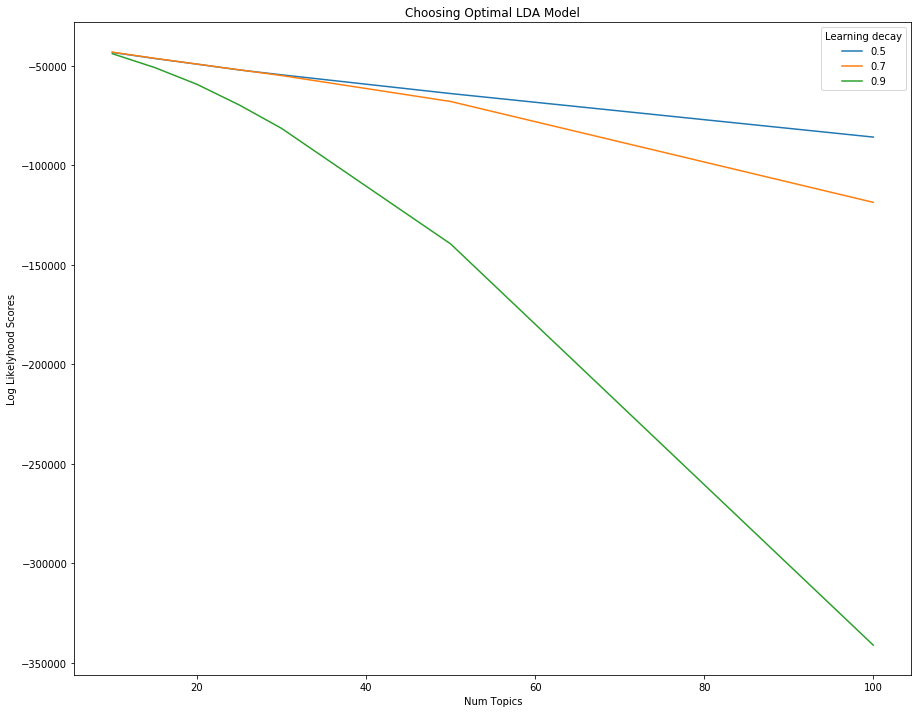

In [174]:
# Show graph
plt.figure(figsize=(15, 12))

plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


From the above plots : Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.7 outperforms both 0.5 and 0.9.
We are thinking the reason is : even though we know that the dataset has 20 distinct topics to start with, some topics could share common keywords. For example, ‘paparazi’ and ‘photographers’ can have a lot of common words. 

So the bottom line is, a lower optimal number of distinct topics (even 10 topics) may be reasonable for this dataset. 

### How to see the dominant topic in each document?
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.
In the table below,  all major topics in a document are written in "Green" and assigned the most dominant topic in its own column.

In [254]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# # Make the pandas dataframe
_df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)# , index=docnames)

# # Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic


# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
#df_document_topics

In [255]:
df_document_topics.data.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0.01,0.53,0.01,0.01,0.01,0.01,0.01,0.42,0.01,0.01,1
1,0.00,0.00,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2
2,0.01,0.01,0.01,0.01,0.01,0.01,0.93,0.01,0.01,0.01,6
3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.94,0.01,0.01,7
4,0.00,0.00,0.00,0.00,0.00,0.00,0.96,0.00,0.00,0.00,6


In [256]:
df_document_topics_with_likes = pd.concat((df_document_topics.data, documents['likes']), axis=1)
df_document_topics_with_likes.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,likes
0,0.01,0.53,0.01,0.01,0.01,0.01,0.01,0.42,0.01,0.01,1,8715
1,0.00,0.00,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,3458
2,0.01,0.01,0.01,0.01,0.01,0.01,0.93,0.01,0.01,0.01,6,8232
3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.94,0.01,0.01,7,9371
4,0.00,0.00,0.00,0.00,0.00,0.00,0.96,0.00,0.00,0.00,6,6184


### 15. Topics distribution across documents


In [180]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution


,Topic Num,Num Documents
0,1,149
1,3,86
2,2,79
3,0,79
4,5,73
5,4,72
6,6,66
7,8,44
8,7,31
9,9,14


### Visualize the LDA model with pyLDAvis
In pyLDAvis, there is a dynamic visualization of topics-keywords distribution:
A good topic model will have non-overlapping, fairly big sized blobs for each topic.Let's see what we will get here.

In [181]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
#panel


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      19.117639        1       1 -105.072571   52.864708
4      15.426231        1       2  -38.074928  172.008209
3      11.652757        1       3  126.285500  -63.535908
5      11.558285        1       4  102.090317  109.508835
0      10.736696        1       5 -226.051987  -30.616892
2       9.742040        1       6   15.083617 -167.611221
6       8.700985        1       7 -158.827927 -178.306244
8       6.339543        1       8 -207.476303  132.990189
7       4.207726        1       9   15.608328    9.529560
9       2.518097        1      10  -82.119492  -73.147293, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
206   Default  47.000000      britain  47.000000  30.0000  30.0000
1111  Default  55.000000      migrant  55.000000  29.0000  29.0000
304   Default  53.000000        china  53.000000  28.0000  28.0000
1104  Default  59.000000       mexico  59.000000  27.0000  27.0000
991   Default  38.000000       london  38.000000  26.0000  26.0000
1973  Default  36.000000       winter  36.000000  25.0000  25.0000
1561  Default  67.000000       russia  67.000000  24.0000  24.0000
656   Default  40.000000         gaza  40.000000  23.0000  23.0000
911   Default  38.000000        korea  38.000000  22.0000  22.0000
1684  Default  32.000000        south  32.000000  21.0000  21.0000
1945  Default  54.000000      weather  54.000000  20.0000  20.0000
588   Default  48.000000     februari  48.000000  19.0000  19.0000
1426  Default  21.000000  pyeongchang  21.000000  18.0000  18.0000
790   Default  43.000000        india  43.000000  17.0000  17.0000
1414  Default  50.000000      protest  50.000000  16.0000  16.0000
1246  Default  20.000000        olymp  20.000000  15.0000  15.0000
190   Default  42.000000       border  42.000000  14.0000  14.0000
249   Default  27.000000      caravan  27.000000  13.0000  13.0000
1280  Default  26.000000  palestinian  26.000000  12.0000  12.0000
1586  Default  37.000000          say  37.000000  11.0000  11.0000
634   Default  44.000000        franc  44.000000  10.0000  10.0000
1913  Default  37.000000      volcano  37.000000   9.0000   9.0000
1934  Default  26.000000   washington  26.000000   8.0000   8.0000
822   Default  26.000000       israel  26.000000   7.0000   7.0000
1688  Default  14.000000        space  14.000000   6.0000   6.0000
227   Default  34.000000   california  34.000000   5.0000   5.0000
584   Default  22.000000      fashion  22.000000   4.0000   4.0000
1852  Default  31.000000        trump  31.000000   3.0000   3.0000
793   Default  27.000000    indonesia  27.000000   2.0000   2.0000
607   Default  21.000000     firework  21.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
954   Topic10   2.348161    leahmilli   3.186977   3.3762  -4.9445
1121  Topic10   2.346846        milli   3.187387   3.3755  -4.9451
1518  Topic10   2.188324        ricki   3.019201   3.3598  -5.0150
57    Topic10   2.187023       arnold   3.018268   3.3595  -5.0156
312   Topic10   3.371334     christma   4.744354   3.3400  -4.5829
325   Topic10   3.493464         clau   5.196860   3.2845  -4.5473
1688  Topic10   9.812995        space  14.662687   3.2801  -3.5145
170   Topic10   2.743165        blast   4.217869   3.2514  -4.7891
1623  Topic10   1.216795       sergey   2.033597   3.1681  -5.6019
909   Topic10   1.211420         kong   2.033326   3.1638  -5.6064
746   Topic10   1.211417     hongkong   2.033898   3.1635  -5.6064
1190  Topic10   1.186997        naval   2.003674   3.1581  -5.6267
1228  Topic10   1.198848    norwegian   2.034766   3.1526  -5.6168
1957  Topic10   1.157268   wheelchair   1.973551   3.1479  -5.6521
953   Topic10   2.279869         leah   3.904638   3.1436  -4.9740
1541  Topic10   1.769873         rome   3.485

### How to see the Topic’s keywords?
The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().
Let’s use this info to construct a weight matrix for all keywords in each topic.

In [182]:

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abidi,academi,accord,accus,action,activist,addisalem,adnan,adnanabidi,adre,...,yenisei,york,young,youth,zammit,zanderaveri,zeya,zhumatov,ziplin,zone
Topic0,0.197406,1.842003,0.102911,0.103511,2.681579,1.019764,0.103326,0.198068,0.239220,0.104106,...,0.103475,1.120926,0.111765,0.104279,0.103758,0.104212,0.103862,0.102921,3.885055,0.103281
Topic1,0.103872,0.103782,0.253695,0.973854,0.109894,0.103951,0.103445,0.103816,0.103549,0.104247,...,5.825147,34.679138,2.898942,2.634058,0.103769,3.499999,0.105372,0.104438,0.103586,2.502772
Topic2,3.879921,0.108266,1.635458,0.103344,0.104526,0.104360,0.103693,3.874895,2.712661,0.103901,...,0.102969,0.224433,0.109224,0.103073,3.455793,0.103749,0.104611,0.104319,0.104292,0.102995
Topic3,0.102884,0.889603,0.856343,0.103957,0.104339,2.560241,0.116695,0.104305,0.103520,3.342905,...,0.111199,0.104249,0.115451,0.104394,0.108653,0.103692,0.109888,0.103863,0.108171,0.108588
Topic4,0.103783,0.109838,4.588293,1.751567,0.104193,0.103533,3.583484,0.103502,0.103579,0.104431,...,0.103933,0.104865,2.816650,0.889915,0.107784,0.103807,4.294408,0.102494,0.969968,0.103398


### Top 15 keywords each topic:
From the above output, we will try to see the top 15 keywords that are representative of the topic.
The show_topics() defined below creates that.
       


In [183]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15) 

In [184]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,china,washington,trump,provinc,wave,presid,stringer,win,celebr,india,vote,septemb,januari,capitol,spain
Topic 1,russia,weather,franc,juli,york,march,snow,citi,brazil,near,protest,view,hurrican,flood,septemb
Topic 2,india,fashion,firework,greec,syria,celebr,plastic,sport,open,rawlin,tenni,women,week,march,water
Topic 3,mexico,migrant,caravan,central,spain,turkey,octob,rescu,australia,worldcup,june,juli,world,soccer,river
Topic 4,say,volcano,indonesia,hawaii,villag,erupt,year,children,hous,peopl,daughter,iraq,lava,ukrain,earthquak
Topic 5,gaza,border,protest,near,california,palestinian,israel,texa,isra,decemb,clash,strip,rohingya,bangladesh,southern
Topic 6,korea,north,wed,nepal,south,flower,natur,korean,april,field,near,march,portug,japan,pool
Topic 7,pyeongchang,winter,olymp,south,februari,korea,winterolymp,india,crash,ceremoni,compet,athlet,women,gala,open
Topic 8,britain,london,switzerland,hors,melvil,tobi,nichol,august,june,plane,canada,nobl,phil,polic,pictur
Topic 9,space,kazakhstan,navi,soyuz,santa,handout,crew,facebook,station,carri,clau,christma,spacecraft,dayton,decemb


In [185]:
type(df_topic_keywords)

pandas.core.frame.DataFrame